<h1><center>Kaggle Competition: [Recruit Restaurant Visitor Forecasting](https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting)</center></h1> 

---
**Summary**

[**1. Data Ingestion & Data Cleaning**](#1.-Data-Ingestion-&-Data-Cleaning)

[**2. Feature Engineering**](#2.-Feature-Engineering)

[**3. Model Training**](#3.-Model-Training)

[**4. Model Evaluation**](#4.-Model-Evaluation)

[**5. Kaggle Submission**](#5.-Kaggle-Submission)

---

# 1. Data Ingestion & Data Cleaning

In [1]:
import pandas as pd
from lib import clean_db  # clean_db is a local module under the 'lib' directory
    
def get_raw_dataframe():
    """ 
    Loads all the .csv files into their respective Dataframes, combines them together and then cleans them.
    This function returns a single Dataframe with all the available data.
    """ 
    if not hasattr(get_raw_dataframe, "raw_df"):
        # 'data': dir that stores all the .csv files
        get_raw_dataframe.raw_df = clean_db.load_from('data')  
        
        # converts 'visit_date' to Datetime object      
        get_raw_dataframe.raw_df.visit_date = pd.to_datetime(get_raw_dataframe.raw_df.visit_date)   
  
    return get_raw_dataframe.raw_df

A Jupyter Widget

In [2]:
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

display(get_raw_dataframe().head())

,air_store_id,visit_date,visitors,genre_name,area_name,latitude,longitude,reservations,day_of_week,holiday_flg
0,air_ba937bf13d40fb24,2016-01-13,25,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,-1.0,Wednesday,0
1,air_ba937bf13d40fb24,2016-01-14,32,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,-1.0,Thursday,0
2,air_ba937bf13d40fb24,2016-01-15,29,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,-1.0,Friday,0
3,air_ba937bf13d40fb24,2016-01-16,22,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,-1.0,Saturday,0
4,air_ba937bf13d40fb24,2016-01-18,6,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,-1.0,Monday,0


# 2. Feature Engineering

In [3]:
def get_dataframe():
    """ 
    Retrieves the raw dataset and engineers the first feature by splitting 'visit_date' into numeric variables: (day, month, year).
    """    
    full_df = get_raw_dataframe()
    df = full_df[ ['air_store_id', 'visit_date', 'visitors', 'day_of_week', 'holiday_flg', 'reservations', 'latitude', 'longitude'] ].copy()
    df['year'] = full_df['visit_date'].dt.year
    df['month'] = full_df['visit_date'].dt.month
    df['day'] = full_df['visit_date'].dt.day
    return df    

In [4]:
def add_feature_dummy_weekdays(df):
    """ 
    Receives a Dataframe and converts 'day_of_week' (a categorical variable) into dummy variables.
    """ 
    return pd.get_dummies(df, columns=['day_of_week'])

In [5]:
def add_feature_visitors_stats(df):
    """ 
    Receives a Dataframe and computes daily visitors' statistics, such as mean/median and also the number of observations (per day of the week).
    """ 
    df.visit_date = pd.to_datetime(df.visit_date)
    df['dow'] = df['visit_date'].apply(lambda x: x.weekday())  # Monday=0, Sunday=6

    # Calculate mean() median() and size() for every restaurant per day of the week
    tmp = df.groupby(['air_store_id','dow']).agg({'visitors' : [np.mean,np.median,np.size]}).reset_index()
    tmp.columns = ['air_store_id', 'dow', 'mean_visitors', 'median_visitors','count_observations']
    return pd.merge(df, tmp, how='left', on=['air_store_id','dow']) 

In [6]:
def add_feature_reservations_stats(df):        
    """ 
    Receives a Dataframe and computes daily reservations' statistics, such as mean and number of observations (per day of the week).
    """ 
    tmp = df.groupby(['air_store_id','dow']).agg({'reservations' : [np.mean,np.size]}).reset_index()
    tmp.columns = ['air_store_id', 'dow', 'mean_reservations', 'count_reservations']    
    return pd.merge(df, tmp, how='left', on=['air_store_id','dow'])        

In [7]:
def add_feature_geographical_dist(df):
    """ 
    Receives a Dataframe and computes store the geografical distance between a restaurant and the most distant restaurant.
    """ 
    df['max_lat_dist'] = df['latitude'].max() - df['latitude']
    df['max_long_dist'] = df['longitude'].max() - df['longitude']
    return df 

In [8]:
def get_feature_names(df):
    """ 
    Receives a Dataframe and returns a list with all the column names that should be used as features.
    """ 
    feature_names = df.columns.values.tolist()
    feature_names.remove('visitors')
    feature_names.remove('visit_date')
    feature_names.remove('air_store_id')
    return feature_names

# 3. Model Training

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectPercentile, f_regression, RFECV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from itertools import compress

# Loads the dataframe and prepare its features
df = get_dataframe()
df = add_feature_dummy_weekdays(df)
df = add_feature_visitors_stats(df)
df = add_feature_reservations_stats(df)
df = add_feature_geographical_dist(df)
df = add_feature_geographical_dist(df)

feature_names = get_feature_names(df)
X = df[feature_names]
y = df.visitors

# Split X,y into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Create the 1st model using GradientBoostingRegressor
gbr_model = GradientBoostingRegressor(n_estimators=200, random_state=7, learning_rate=0.1, max_depth=7) # with log1p/expm1: 0.514
gbr_model.fit(X_train, np.log1p(y_train))

# Create the 2nd model using RandomForestRegressor
rfr_model = RandomForestRegressor(n_jobs=6, bootstrap=True, max_depth=13, max_features='log2', min_samples_leaf=4, min_samples_split=5, n_estimators=400) # with log1p/expm1: 0.517
rfr_model.fit(X_train, np.log1p(y_train))

print('>>> Training done!')

>>> Training done!


# 4. Model Evaluation


>>> RMSLE Score: 11.3633287598 



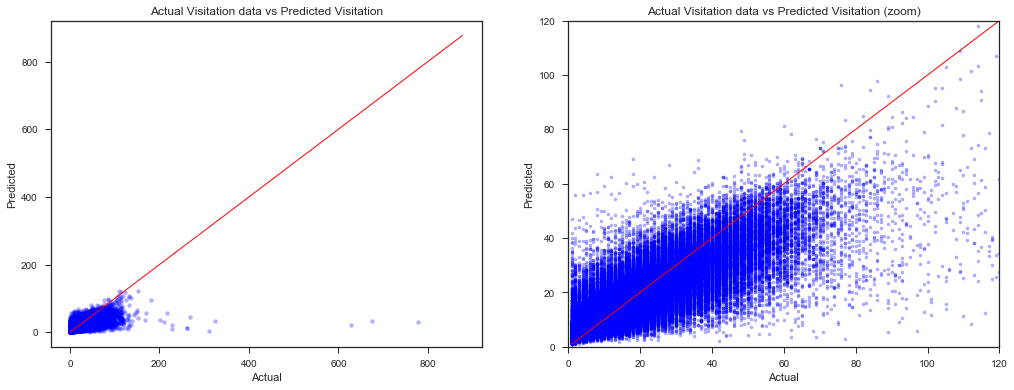

In [10]:
from lib import gfx  # gfx is another local module under the 'lib' directory
from sklearn import metrics

# The prediction is calculated as the arithmetic mean of both model's predictions
gbr_visitors = np.expm1(gbr_model.predict(X_test))
rfr_visitors = np.expm1(rfr_model.predict(X_test))
y_pred = (gbr_visitors + rfr_visitors) / 2

rmsle_score = metrics.mean_squared_error(y_test, y_pred) ** 0.5
print('\n>>> RMSLE Score:', rmsle_score, '\n')

# Plot Actual visitation data against Predicted visition
gfx.plot_actual_vs_predicted(y, y_test, y_pred)

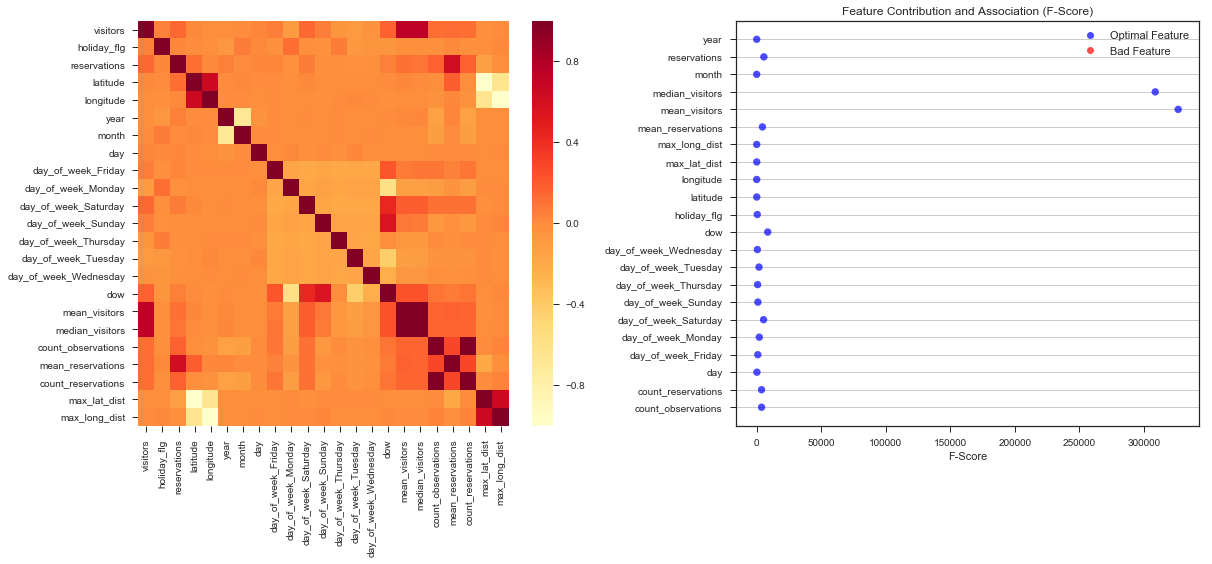

In [11]:
plt.figure(figsize=(17,8))

# Plots the correlation between different features of the dataframe
plt.subplot(1, 2, 1)
ax = sns.heatmap(df.corr(), square=True, cmap='YlOrRd')
ax.set_aspect('auto')

# Plot feature contributions and associations
feature_names = get_feature_names(df)
gfx.plot_feature_importance(df, feature_names, True)

plt.tight_layout(h_pad=1)
plt.show()

# 5. Kaggle Submission

In [12]:
# load_submission_file(): reads sample_submissions.csv and returns a DataFrame with extra columns parsed from 'id'
def load_submission_file():
    sub_df = pd.read_csv('data/sample_submission.csv')    
    
    # parse store_id from: air_00a91d42b08b08d9_2017-04-23
    sub_df['air_store_id'] = sub_df.id.map(lambda x: '_'.join(x.split('_')[:-1]))  
    
    # parse date from: from: air_00a91d42b08b08d9_2017-04-23
    sub_df['visit_date'] = sub_df.id.map(lambda x: x.split('_')[2])
    
    # erase visitors column
    sub_df.drop('visitors', axis=1, inplace=True)    
    #sub_df.drop('id', axis=1, inplace=True) 
          
    return sub_df

In [13]:
def build_submission_features(sub_df, short_df):        
    # To fill the column 'holiday_flg', pretend submission's visit_date is from the previous year and copy those holidays
    sub_df['visit_date'] = sub_df['visit_date'].str.replace('2017','2016')
    sub_df.visit_date = pd.to_datetime(sub_df.visit_date)

    # Drop duplicates in holidays_df to avoid adding more rows to the merged Dataframe
    holidays_df = short_df[['visit_date', 'holiday_flg']]
    holidays_df = holidays_df.drop_duplicates(subset=['visit_date'])

    ### Add HOLIDAY_FLG: fill with holidays from 2016
    sub_df = pd.merge(sub_df, holidays_df[['visit_date', 'holiday_flg']], on='visit_date', how='left')

    # Convert 'visit_date' to string and revert back to the original year (2017)
    sub_df['visit_date'] = sub_df['visit_date'].dt.strftime('%Y-%m-%d')
    sub_df['visit_date'] = sub_df['visit_date'].str.replace('2016','2017')
    sub_df.visit_date = pd.to_datetime(sub_df.visit_date)

    # Add MAX_LAT_DIST, MAX_LONG_DIST, LATITUDE and LONGITUDE
    geo_df = short_df[['air_store_id', 'max_lat_dist', 'max_long_dist', 'latitude', 'longitude']].drop_duplicates()
    sub_df = pd.merge(sub_df, geo_df, how='left', on=['air_store_id']) 
    
    # Add 'DAY_OF_WEEK' column
    import calendar
    sub_df['day_of_week'] = sub_df['visit_date'].apply(lambda x: (calendar.day_name[x.weekday()]))
    sub_df = pd.get_dummies(sub_df, columns=['day_of_week'])

    # Add YEAR, MONTH, DAY columns
    sub_df['year'] = sub_df['visit_date'].dt.year
    sub_df['month'] = sub_df['visit_date'].dt.month
    sub_df['day'] = sub_df['visit_date'].dt.day
    
    # Add DOW (Day Of the Week)
    sub_df['dow'] = sub_df['visit_date'].apply(lambda x: x.weekday())  # Monday=0, Sunday=6
    
    # Add visitor-statistics    
    stats_df = short_df[['air_store_id','dow', 'mean_visitors', 'median_visitors', 'count_observations']]
    stats_df = stats_df.drop_duplicates()    
    sub_df = pd.merge(sub_df, stats_df, how='left', on=['air_store_id','dow'])          

    # At this point, some restaurants will have NaNs in visitor-statistics columns because 
    # there was no training data of that restaurant for that particular weekday (ex: Monday).
    # Check with: 
    #    display(short_df[(short_df.air_store_id == 'air_0164b9927d20bcc3') & (short_df.dow == 6)].head())
    # Print rows with NaN values: 
    #    missing_stats_df = sub_df[sub_df.isnull().any(axis=1)]
    #
    # But here is how we are going to handle it:
    sub_df = sub_df.fillna(sub_df.mean())
        
    # Add reservation
    sub_df['reservations'] = -1
    
    # Add reservation statistics
    stats_df = short_df[['air_store_id','dow', 'mean_reservations', 'count_reservations']]
    stats_df = stats_df.drop_duplicates()    
    sub_df = pd.merge(sub_df, stats_df, how='left', on=['air_store_id','dow'])  
    sub_df = sub_df.fillna(sub_df.mean())                  

    # Delete unecessary columns
    del sub_df['air_store_id']
    del sub_df['visit_date'] 
    
    return sub_df

In [14]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

### Load sample_submissions.csv into the DataFrame that's used for submission on Kaggle
sub_df = load_submission_file()
print('>>> sub_df (original) shape=', sub_df.shape)
# display(sub_df.head(2))

### Do some magic and create the necessary features for prediction
sub_df = build_submission_features(sub_df, df)
print('>>> sub_df (features) shape=', sub_df.shape)
# display(sub_df.head(2))

### Loads the raw dataframe and prepare its features
df = get_dataframe()
df = add_feature_dummy_weekdays(df)
df = add_feature_visitors_stats(df)
df = add_feature_reservations_stats(df)
df = add_feature_geographical_dist(df)
df = add_feature_geographical_dist(df)

# Create (X,y): the multidimensional array of features and the array with the target value (visitors)
feature_names = get_feature_names(df)
X = df[feature_names]
y = df.visitors

### Fit a GradientBoostingRegressor model and use it to predict the amount of visitors for each restaurant
gbr_model = GradientBoostingRegressor(n_estimators=200, random_state=7, learning_rate=0.1, max_depth=7) # with log, exp: 0.514
gbr_model.fit(X, np.log1p(y))

### Fit a RandomForestRegressor model and use it to predict the amount of visitors for each restaurant
rfr_model = RandomForestRegressor(n_jobs=6, bootstrap=True, max_depth=13, max_features='log2', min_samples_leaf=4, min_samples_split=5, n_estimators=400) # with log, exp: 0.517
rfr_model.fit(X, np.log1p(y))

# Store prediction as 'visitors'
X_features = sub_df[feature_names]
gbr_visitors = np.expm1(gbr_model.predict(X_features))
rfr_visitors = np.expm1(rfr_model.predict(X_features))
sub_df['visitors'] = (gbr_visitors + rfr_visitors) / 2

### The final dataset must have only 2 columns: id and visitors
final_df = sub_df[['id', 'visitors']]

### Save the result to disk as 'prediction.csv'
final_df.to_csv('prediction.csv', index=False)
print('\n>>> Submission file', final_df.shape, 'saved as: prediction.csv')
display(final_df.tail(5))

>>> sub_df (original) shape= (32019, 3)
>>> sub_df (features) shape= (32019, 23)

>>> Submission file (32019, 2) saved as: prediction.csv


,id,visitors
32014,air_fff68b929994bfbd_2017-05-27,6.877109
32015,air_fff68b929994bfbd_2017-05-28,3.469029
32016,air_fff68b929994bfbd_2017-05-29,3.681899
32017,air_fff68b929994bfbd_2017-05-30,3.836242
32018,air_fff68b929994bfbd_2017-05-31,3.991819
